In [79]:
import numpy as np
import torch
import cv2
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import dataloader
import torchvision.transforms.functional as TF


In [80]:
import mymodels

model_structure = mymodels.ft_net(751)
#model = load_network(model_structure)
model=model_structure

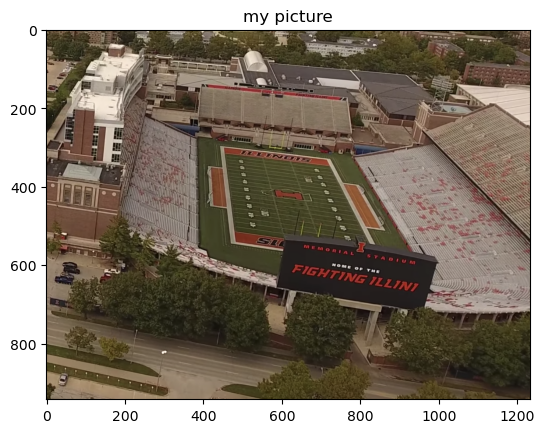

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [97]:
from matplotlib import pyplot as plt
import cv2
import skimage
from torchvision.io import read_image, ImageReadMode

img = plt.imread('test\\4K_drone\\0000\\5.png')
#image=skimage.img_as_float(img)
#img = img.astype(float)
plt.imshow(img)
plt.title('my picture')
plt.show()
h, w = 256, 128
#img = img.astype('uint8')
img = read_image('test\\4K_drone\\0000\\5.png', mode=ImageReadMode.RGB)
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((h, w), interpolation=3),
            transforms.Pad(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Convert the image to Torch tensor
tensor = transform(img)
  
# print the converted image tensor
print(tensor)
print(tensor.shape)

In [101]:
outputs = model(tensor.unsqueeze(0)) 
# ---- L2-norm Feature ------
ff = outputs.data.cpu()
fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
ff = ff.div(fnorm.expand_as(ff))

In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function, division

import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
from utils_server import load_network
import os
import scipy.io
import yaml
import math
from tqdm import tqdm
from mymodels import ft_net,ft_net_dense,ft_net_hr,ft_net_swin,ft_net_swinv2,ft_net_efficient,ft_net_NAS,ft_net_convnext,PCB,PCB_test
try:
    from apex.fp16_utils import *
except ImportError: # will be 3.x series
    print('This is not an error. If you want to use low precision, i.e., fp16, please install the apex with cuda support (https://github.com/NVIDIA/apex) and update pytorch to 1.0')
######################################################################

C:\Users\abine\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abine\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This is not an error. If you want to use low precision, i.e., fp16, please install the apex with cuda support (https://github.com/NVIDIA/apex) and update pytorch to 1.0


In [2]:
###load config###
# load the training config
#config_path = os.path.join('./model',opt.name,'opts.yaml')
#with open(config_path, 'r') as stream:
#        config = yaml.load(stream, Loader=yaml.FullLoader) # for the new pyyaml via 'conda install pyyaml'
fp16 = False
PCB1 = True
use_dense = True
use_NAS = False
stride = 2
use_swin = False
use_swinv2 = False
use_convnext = False
#if 'use_efficient' in config:
#    opt.use_efficient = config['use_efficient']
use_efficient= True
#if 'use_hr' in config:
#    opt.use_hr = config['use_hr']
use_hr= True

nclasses = 751 


ibn=True
linear_num=512
#str_ids = opt.gpu_ids.split(',')
which_epoch = 'last'
name = 'ft_ResNet50'
test_dir = 'test'

gpu_ids = []
#for str_id in str_ids:
#    id = int(str_id)
#   if id >=0:
#        gpu_ids.append(id)
ms='1'
print('We use the scale: %s'%ms)
str_ms = ms.split(',')
ms = []
for s in str_ms:
    s_f = float(s)
    ms.append(math.sqrt(s_f))

# set gpu ids
if len(gpu_ids)>0:
    torch.cuda.set_device(gpu_ids[0])
    cudnn.benchmark = True

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
if use_swin:
    h, w = 224, 224
else:
    h, w = 256, 128

data_transforms = transforms.Compose([
        transforms.Resize((h, w), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ############### Ten Crop        
        #transforms.TenCrop(224),
        #transforms.Lambda(lambda crops: torch.stack(
         #   [transforms.ToTensor()(crop) 
          #      for crop in crops]
           # )),
        #transforms.Lambda(lambda crops: torch.stack(
         #   [transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(crop)
          #       for crop in crops]
          # ))
])

if PCB1:
    data_transforms = transforms.Compose([
        transforms.Resize((256,256), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    h, w = 256, 256


data_dir = test_dir
multi=False

We use the scale: 1


In [3]:
print(os.path.join(data_dir,'query_satellite'))
image_datasets_query = {x: datasets.ImageFolder(os.path.join(data_dir,x) ,data_transforms) for x in ['query_satellite','query_drone']}

image_datasets_gallery = {x: datasets.ImageFolder(os.path.join(data_dir,x) ,data_transforms) for x in ['gallery_satellite','gallery_drone']}

image_datasets = {**image_datasets_query, **image_datasets_gallery}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                         shuffle=False, num_workers=4) for x in ['gallery_satellite', 'gallery_drone','query_satellite','query_drone']}

test\query_satellite


In [4]:
#F:\univdataset\University-Release\test

In [5]:
pwd

'F:\\univdataset\\University-Release'

In [6]:
def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

def which_view(name):
    if 'satellite' in name:
        return 1
    elif 'street' in name:
        return 2
    elif 'drone' in name:
        return 3
    else:
        print('unknown view')
    return -1


In [7]:
def extract_feature(model,dataloaders, view_index = 1):
    features = torch.FloatTensor()
    count = 0
    views=2
    for data in tqdm(dataloaders):
        img, label = data
        n, c, h, w = img.size()
        count += n
        for i in range(2):
            if(i==1):
                img = fliplr(img)
            input_img = Variable(img)
            for scale in ms:
                if scale != 1:
                    # bicubic is only  available in pytorch>= 1.1
                    input_img = nn.functional.interpolate(input_img, scale_factor=scale, mode='bilinear', align_corners=False)
                if views ==2:
                    if view_index == 1:
                        outputs, _ = model(input_img, None)
                    elif view_index ==3:
                        _, outputs = model(None, input_img)
                elif views ==3:
                    if view_index == 1:
                        outputs, _, _ = model(input_img, None, None)
                    elif view_index ==2:
                        _, outputs, _ = model(None, input_img, None)
                    elif view_index ==3:
                        _, _, outputs = model(None, None, input_img)
                if i==0:
                    ff = outputs
                else:
                    ff += outputs
        # norm feature
        if len(ff.shape)==3:
            fnorm = torch.norm(ff, p=2, dim=1, keepdim=True) * np.sqrt(ff.size(-1))
            ff = ff.div(fnorm.expand_as(ff))
            ff = ff.view(ff.size(0), -1)
        else:
            fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
            ff = ff.div(fnorm.expand_as(ff))

        features = torch.cat((features,ff.data.cpu()), 0)
    return features



In [8]:
def get_id(img_path):
    camera_id = []
    labels = []
    paths = []
    for path, v in img_path:
        folder_name = os.path.basename(os.path.dirname(path))
        labels.append(int(folder_name))
        paths.append(path)
    return labels, paths

In [9]:
######################################################################
# Load Collected data Trained model
print('-------test-----------')
opt=1
model = load_network()
print(1)
# model.classifier.classifier = nn.Sequential()
print(model)

-------test-----------
===========building transformer===========
using Transformer_type: vit_small_patch16_224_FSRA as a backbone
Load the model from checkpoint
1
two_view_net(
  (model_1): build_transformer(
    (transformer): FSRA(
      (patch_embed): PatchEmbed_overlap(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_fea

In [10]:
model = model.eval()
#if use_gpu:
#    model = model.cuda()

# Extract feature
since = time.time()
mode=1
if mode==1:
    query_name = 'query_satellite'
    gallery_name = 'gallery_drone'
elif mode==2:
    query_name = 'query_drone'
    gallery_name = 'gallery_satellite'
else:
    raise Exception("opt.mode is not required")

#gallery_name = 'gallery_street'
#query_name = 'query_street'
which_gallery = which_view(gallery_name)
which_query = which_view(query_name)
print('%d -> %d:'%(which_query, which_gallery))
print(query_name.split("_")[-1],"->",gallery_name.split("_")[-1])

1 -> 3:
satellite -> drone


In [11]:

gallery_path = image_datasets[gallery_name].imgs
f = open('gallery_name.txt','w')
for p in gallery_path:
    f.write(p[0]+'\n')
query_path = image_datasets[query_name].imgs
f = open('query_name.txt','w')
for p in query_path:
    f.write(p[0]+'\n')

gallery_label, gallery_path  = get_id(gallery_path)
query_label, query_path  = get_id(query_path)

In [12]:
if __name__ == "__main__":
    with torch.no_grad():
        query_feature = extract_feature(model,dataloaders[query_name], which_query)
        gallery_feature = extract_feature(model,dataloaders[gallery_name], which_gallery)

    # For street-view image, we use the avg feature as the final feature.
    '''
    if which_query == 2:
        new_query_label = np.unique(query_label)
        new_query_feature = torch.FloatTensor(len(new_query_label) ,512).zero_()
        for i, query_index in enumerate(new_query_label):
            new_query_feature[i,:] = torch.sum(query_feature[query_label == query_index, :], dim=0)
        query_feature = new_query_feature
        fnorm = torch.norm(query_feature, p=2, dim=1, keepdim=True)
        query_feature = query_feature.div(fnorm.expand_as(query_feature))
        query_label   = new_query_label
    elif which_gallery == 2:
        new_gallery_label = np.unique(gallery_label)
        new_gallery_feature = torch.FloatTensor(len(new_gallery_label), 512).zero_()
        for i, gallery_index in enumerate(new_gallery_label):
            new_gallery_feature[i,:] = torch.sum(gallery_feature[gallery_label == gallery_index, :], dim=0)
        gallery_feature = new_gallery_feature
        fnorm = torch.norm(gallery_feature, p=2, dim=1, keepdim=True)
        gallery_feature = gallery_feature.div(fnorm.expand_as(gallery_feature))
        gallery_label   = new_gallery_label
    '''
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # Save to Matlab for check
    result = {'gallery_f':gallery_feature.numpy(),'gallery_label':gallery_label,'gallery_path':gallery_path,'query_f':query_feature.numpy(),'query_label':query_label, 'query_path':query_path}
    scipy.io.savemat('pytorch_result.mat',result)

    result = 'result.txt'
    os.system('python evaluate_gpu.py | tee -a %s'%result)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 402/402 [8:48:39<00:00, 78.91s/it]


Test complete in 535m 24s


In [19]:
result = 'result.txt'
os.system('python evaluate_gpu.py | tee -a %s'%result)

255

In [29]:
pwd

'F:\\univdataset\\University-Release'

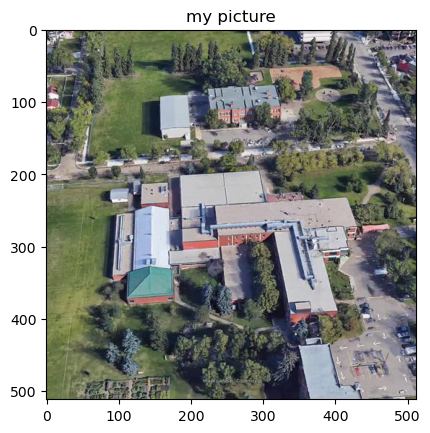

In [50]:
from matplotlib import pyplot as plt
import cv2
import skimage

img = plt.imread("test\\gallery_drone\\0000\\image-01.jpeg")
#image=skimage.img_as_float(img)
#img = img.astype(float)
plt.imshow(img)
plt.title('my picture')
plt.show()